In [1]:
import torch
import cv2
import matplotlib.pyplot as plt

DEVICE = "mps"

# Pose 2D Model

In [2]:
from simple_pose2d_model import get_pose2d_model

pose2d_model_config, pose2d_model = get_pose2d_model(
    pose2d_model_config_path="configs/halpe_26/resnet/256x192_res50_lr1e-3_1x.yaml",
    pose2d_checkpoint_path="pretrained_models/halpe26_fast_res50_256x192.pth",
    device=DEVICE
)

/Users/uinone/.local/share/virtualenvs/AlphaPose-HZ1PtCuD/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/uinone/.local/share/virtualenvs/AlphaPose-HZ1PtCuD/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2D Pose model ready!


# Detection Model

In [3]:
from simple_detection_loader import get_detection_model

detection_model = get_detection_model(
    device=DEVICE, 
    pose2d_model_config=pose2d_model_config
)

# Pose 3D Model

In [4]:
from simple_pose3d_model import get_pose3d_model

pose3d_model = get_pose3d_model(
    pose3d_config_path="MotionBERT/configs/pose3d/MB_ft_h36m.yaml",
    pose3d_weight_path="MotionBERT/weights/MB_ft_h36m.bin",
    device=DEVICE
)

3D pose model ready!


# DataWriter

In [5]:
from simpe_datawriter import DataWriter
from simple_detection_loader import DetectionOpt

In [6]:
pose2d_estimator = DataWriter(
    pose2d_model_config, 
    DetectionOpt(DEVICE)
)

# Visualize

Loading YOLO model..


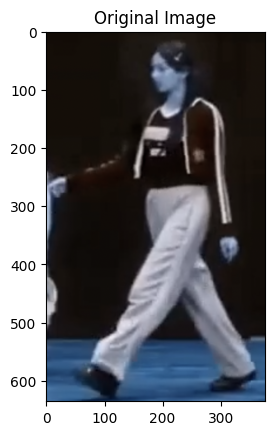

In [6]:
img = cv2.imread("examples/demo/custom_example_2.png")[...,::-1]

plt.title("Original Image")
plt.imshow(img)

img_h, img_w = img.shape[:2]

with torch.no_grad():
    # inps, orig_img, boxes, scores, ids, cropped_boxes
    detection_outp = detection_model.process(img).read()

(inps, orig_img, boxes, scores, ids, cropped_boxes) = detection_outp

# Pose 2D Visualize

In [11]:
with torch.no_grad():
    hm = pose2d_model(inps.to("mps")).cpu()

pose2d_estimator.save(boxes, scores, ids, hm, cropped_boxes, orig_img)
hp_outp = pose2d_estimator.start()

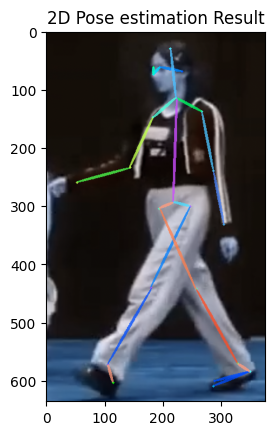

In [12]:
from simple_pose2d_visualizer import get_pose2d_result

vis_pose2d = get_pose2d_result(img, hp_outp)

plt.title("2D Pose estimation Result")
plt.imshow(vis_pose2d)

# 3D Pose estimation

In [13]:
keypoints = torch.concat([hp_outp["result"][0]['keypoints'], hp_outp["result"][0]['kp_score']], dim=-1)
keypoints = torch.unsqueeze(keypoints, dim=0)

torch.Size([1, 26, 3])

In [14]:
from MotionBERT.lib.data.dataset_wild import WildDetDataset

wild_dataset = WildDetDataset(
    clip_len=1,
    image_size=img.shape[:2][::-1],
)
wild_dataset.add_data(keypoints)
test_2d_kp = torch.FloatTensor(wild_dataset[0][0])
test_2d_kp = torch.unsqueeze(test_2d_kp, dim=0)

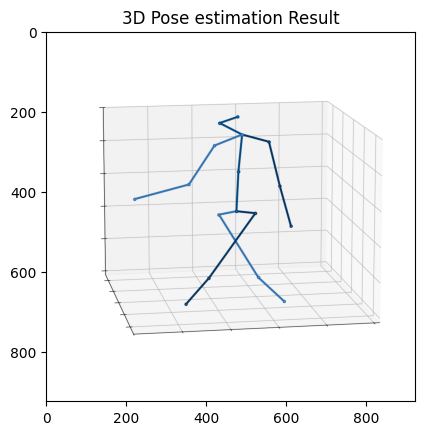

In [15]:
from simple_pose3d_visualizer import get_pose3d_result

with torch.no_grad():
    pose3d_outp = pose3d_model(test_2d_kp.to(DEVICE)).cpu()

pose3d_vis = get_pose3d_result(
    pose3d_outp_single=pose3d_outp[0],
    elevation=12.,
    angle=80
)

plt.title("3D Pose estimation Result")
plt.imshow(pose3d_vis)